   # Math 495 Final Project

 ## <span style="color: purple;">Kordell Schrock & Clark Reimers</span>

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("GameSales2016.csv") #import dataset
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


 ## <span style="color: purple;">Clean the Data</span>

In [8]:
df = df.dropna() #remove NA rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   object 
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(9), object(7)
memory usage: 906.4+ KB


In [15]:
#'User_Score' rows with 'tbd' values to be dropped
df = df.drop(df[df.User_Score == 'tbd'].index)
# Replace old videogame rating convention "K-A" with "E"
df['Rating']=df['Rating'].replace(['K-A'], 'E')
#Convert 'Year_of_Release' from float to integer
df['Year_of_Release']=df['Year_of_Release'].astype(int)
#Convert 'User_Score' from object to float
df['User_Score']=10*df['User_Score'].astype(float)
#rename column
df = df.rename(columns={"Year_of_Release": "Year"})
#calculate how old a Video Game is
df["Age"] = 2018 - df["Year"]
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80000.0,322.0,Nintendo,E,12
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83000.0,709.0,Nintendo,E,10
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80000.0,192.0,Nintendo,E,9
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85000.0,431.0,Nintendo,E,12
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66000.0,129.0,Nintendo,E,12


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
noObjects = df.select_dtypes(exclude=['object']) #remove objects
Xcols= noObjects.drop([], axis=1)
vif = pd.DataFrame()
vif["features"] = Xcols.columns
vif["vif_Factor"] = [variance_inflation_factor(Xcols.values, i) for i in range(Xcols.shape[1])]
print(vif) #vif Factor is helpful to find columns to remove since they are not good independent variables
#VIF factor under 10 is good for independent variables

          features     vif_Factor
0  Year_of_Release      33.849441
1         NA_Sales   31071.946995
2         EU_Sales   15037.048889
3         JP_Sales    2472.613112
4      Other_Sales    2271.673558
5     Global_Sales  126976.903063
6     Critic_Score      48.861177
7     Critic_Count       4.374225
8       User_Score      40.637793
9       User_Count       1.381430


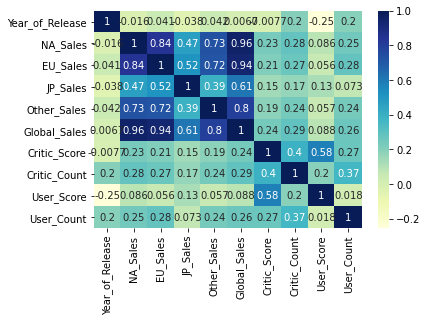

In [11]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu") #print the heat map
plt.show()

In [17]:
scored = df.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,71856.263736,174.722344,10.563223
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,14399.416644,587.428538,4.211248
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5000.000000,4.000000,2.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65000.000000,11.000000,7.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75000.000000,27.000000,11.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,82000.000000,89.000000,14.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96000.000000,10665.000000,33.000000


In [31]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
numeric_subset = scored.select_dtypes("number").drop(columns=["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Year"])

# Select the categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encode
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global_Sales"].dropna().sort_values()